In [1]:
import numpy as np
# import jax.numpy as np
# from jax import grad

import matplotlib.pyplot as plt
from rk_integrate import rk_integrate
from deathrate import a
from newton import newtonNd_to_1d
from scipy.optimize import minimize

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

def better_imshow(row_vals, col_vals, data, ax=None):
    #row_vals and col_vals are the data that was swept over
    assert len(row_vals) == data.shape[0], 'length of row_vals does not match shape of data'
    assert len(col_vals) == data.shape[1], 'length of col_vals does not match shape of data'
    if ax == None:
        plt.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
    else:
        ax.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
        
        
def plot_results(x, L_list, tlist):
    n_t = x[:,2:]
    better_imshow(L_list, tlist, n_t.T)
    plt.ylabel('L (particle size)')
    plt.xlabel('time')
    plt.colorbar()
    plt.show()

    plt.plot(tlist, x[:,0]) 
    plt.title('supersaturation')
    plt.xlabel('t')
    plt.show()

    plt.plot(tlist, x[:,1]) 
    plt.title('volume')
    plt.xlabel('t')

Type for n <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
This is the size of x0 1000
Data type x0[0:8] <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=3/0)>
Data type np.array([0,1,2,3,4,5,6,7]) <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
hp_M Traced<ShapedArray(float32[1000])>with<DynamicJaxprTrace(level=3/0)>
hm_M Traced<ShapedArray(float32[1000])>with<DynamicJaxprTrace(level=3/0)>
Type for dGn_dL <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
 We are in dndt
size of B (1000,)
size of D (1000,)
size of n (1000,)
size of dlogV_dt ()
size of dGn_dL (1000,)
We are in evalf


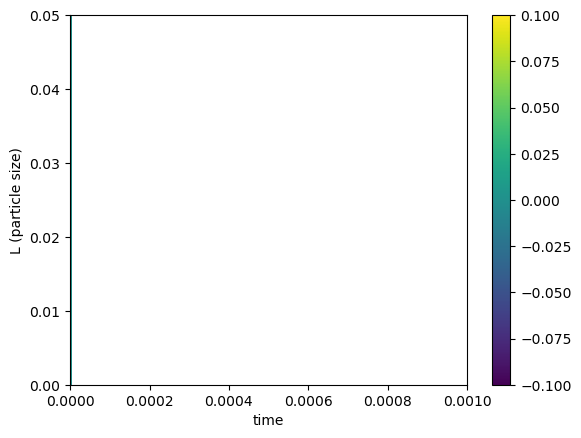

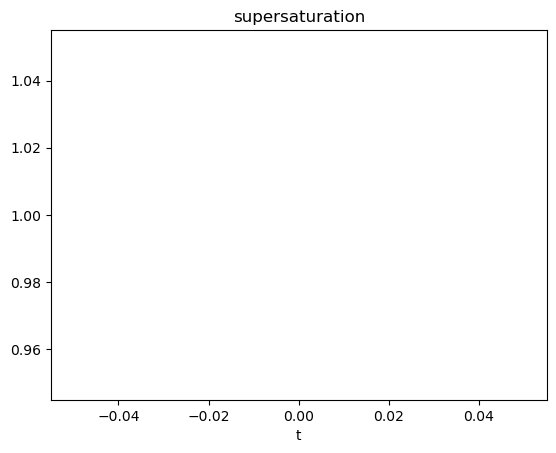

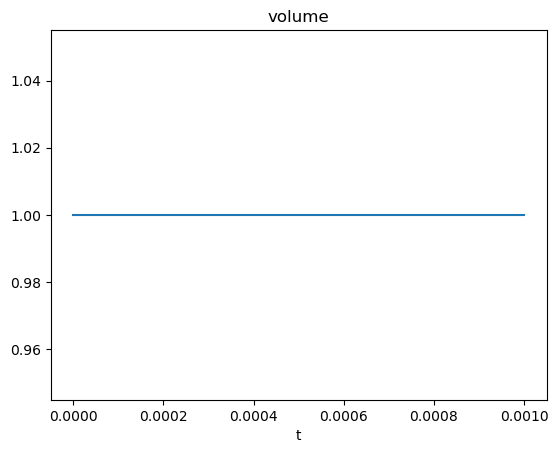

In [2]:
L_list = np.linspace(0,0.05, 1000)  # uniform dL assumed below
# tlist = np.linspace(0,30,1000) 
tlist = np.linspace(0,1e-3,100) 


S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution
x0 = np.hstack([S0, V0, n0])

# target parameters we will try to recover
p_targ = {
    'L_list' : L_list,
    'E' :  1e-6, #evaporation rate
    'rho' : 1200, # density of the crystal
    'k_v' : 1, #goes in N_C, volumetric shape factor
    'k_g' : 1e-3, #growth rate constant m/s
    'g' : 1, #power constant for growth
    'k_N' : 1e5, #nucleation rate constant 
    'alpha' :2, #power constant for nucleation
    'weno': False  # use weno or not for differentiation w.r.t. L
     }

#integrate the equations

x_targ = rk_integrate(x0, t_vec = tlist, p = p_targ) 

plot_results(x_targ, L_list, tlist)

In [3]:
print(x_targ)

[[ 1.  1.  0. ...  0.  0.  0.]
 [nan  1. nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 ...
 [nan  1. nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]]


In [4]:
# cost function reuses x0, tlist, L_list from above
# and also some of the things that we don't need to fit, like rho, k_v
def cost(pvec):
    p = {
    "L_list" : L_list, #discretization bins
    'E' :  1e-6, #pvec[0], #evaporation rate
    'rho' : 1200, # density of the crystal
    'k_v' : 1, #goes in N_C, volumetric shape factor
    'k_g' : pvec[0], #growth rate constant m/s
    'g' : pvec[1], #power constant for growth
    'k_N' : pvec[2], #nucleation rate constant 
    'alpha' :pvec[3], #power constant for nucleation
    }
    
    x_t = rk_integrate(x0, t_vec = tlist, p = p) 
    
    c = np.linalg.norm(x_t[:, 2:] - x_targ[:, 2:])**2
    
    # that c is ridiculously big lol, maybe normalize by the size of x_targ?
    c = c/np.linalg.norm(x_targ)
    
    # print('c:', c)
    # print('pvec:', pvec)
    # jax.debug.print(str(c))
    # print(type(pvec))
    if str(type(pvec)) in ["<class 'numpy.ndarray'>", "<class 'jaxlib.xla_extension.ArrayImpl'>"]:
        print(c)
        # print(pvec)
    return c
    
pvec_guess = np.array([
    1e-3,  # k_g, growth rate constant m/s
    1,  # g, power constant for growth
    1e5,  # k_N, nucleation rate constant 
    2  # alpha, power constant for nucleation
    ])

# cost(pvec)

# grad(cost)(pvec_guess)

#I'm just curious to do a linecut, see how sensitive it is?
# sweep over growth rate constant
# k_g_list = np.linspace(0.5e6,1.5e6,31)
# costs = []
# for k_g in k_g_list:
#     pvec_guess = pvec_guess.at[3].set(k_g)
#     costs.append(cost(pvec_guess))


In [5]:
plt.plot(k_g_list, costs) #nice!

NameError: name 'k_g_list' is not defined

In [ ]:
# ok now let's try a full optimization

pvec_guess = np.array([
    1e-3,  # k_g, growth rate constant m/s
    1.001,  # g, power constant for growth
    1e5,  # k_N, nucleation rate constant 
    2  # alpha, power constant for nucleation
    ])


cost_with_normalized_params = lambda pvec: cost(pvec*pvec_guess)

# res = minimize(cost, pvec_guess, jac=grad(cost), options={'maxiter': 10})
res = minimize(cost_with_normalized_params, x0=np.ones_like(pvec_guess), 
               jac=grad(cost_with_normalized_params), options={'maxiter':10})

# res = minimize(cost_with_normalized_params, x0=np.ones_like(pvec_guess), 
#                jac=None, options={'maxiter':10})


3.12025
nan
nan
nan
nan
620845700.0


KeyboardInterrupt: 

In [ ]:
res.x*pvec_guess

Array([1.00044225e+06, 3.01127648e+00, 9.99430234e+04, 4.79469776e+00],      dtype=float32)

In [ ]:
# ok great that seems to work fairly well. So then what do we want to test...

# some question of how far parameters can be moved before it fails to converge?

# or rather... how much data do you really need?
